<a href="https://colab.research.google.com/github/lherron2/thermomaps-ising/blob/main/thermomaps_ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/lherron2/thermomaps-ising.git
%cd thermomaps-ising/thermomaps-root
! pip -q install .
! pip install -qr requirements.txt
%cd -

Cloning into 'thermomaps-ising'...
remote: Enumerating objects: 443, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 443 (delta 81), reused 149 (delta 58), pack-reused 265
Receiving objects: 100% (443/443), 184.15 KiB | 12.28 MiB/s, done.
Resolving deltas: 100% (222/222), done.
/content/thermomaps-ising/thermomaps-root
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 927.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.3 MB/s eta 0:00:00
/content


In [51]:
import numpy as np
import matplotlib.pyplot as plt

from ising.observables import Energy, Magnetization
from ising.samplers import SwendsenWangSampler, SingleSpinFlipSampler
from ising.base import IsingModel

from data.trajectory import EnsembleTrajectory, MultiEnsembleTrajectory
from data.dataset import MultiEnsembleDataset
from data.generic import Summary

from tm.core.prior import GlobalEquilibriumHarmonicPrior, UnitNormalPrior
from tm.core.backbone import ConvBackbone
from tm.core.diffusion_model import DiffusionTrainer, SteeredDiffusionSampler
from tm.core.diffusion_process import VPDiffusion
from tm.architectures.unet_2d_mid_attn import Unet2D


In [71]:
trajectories = []
for temperature in np.arange(0.3, 3.5, 0.2):
  IM = IsingModel(sampler=SwendsenWangSampler, size = 8, warmup = 1000, temp = np.round(temperature,1), Jx = 1, Jy = 1)
  IM.simulate(steps = 5000, observables = [Energy(Jx = 1, Jy = 1), Magnetization()], sampling_frequency = 1)
  trajectories.append(IM.trajectory)
dataset = MultiEnsembleDataset(trajectories, Summary())

In [117]:
df = dataset.to_dataframe()
df

,index,name,size,temperature,Jx,Jy,sampler
0,0,IsingModel,8,0.3,1,1,SwendsenWang
1,1,IsingModel,8,0.5,1,1,SwendsenWang
2,2,IsingModel,8,0.7,1,1,SwendsenWang
3,3,IsingModel,8,0.9,1,1,SwendsenWang
4,4,IsingModel,8,1.1,1,1,SwendsenWang
5,5,IsingModel,8,1.3,1,1,SwendsenWang
6,6,IsingModel,8,1.5,1,1,SwendsenWang
7,7,IsingModel,8,1.7,1,1,SwendsenWang
8,8,IsingModel,8,1.9,1,1,SwendsenWang
9,9,IsingModel,8,2.1,1,1,SwendsenWang


In [ ]:
sub_df = df[df['temperature'].isin([1.5,2.5])]
sub_dataset = dataset.from_dataframe(sub_df)
sub_df

In [123]:
simulated_M_v_T_mean = {t.state_variables['temperature']: t.observables['magnetization'].quantity.mean() for t in dataset.trajectories}
simulated_E_v_T_mean = {t.state_variables['temperature']: t.observables['energy'].quantity.mean() for t in dataset.trajectories}
simulated_M_v_T_std = {t.state_variables['temperature']: t.observables['magnetization'].quantity.std() for t in dataset.trajectories}
simulated_E_v_T_std = {t.state_variables['temperature']: t.observables['energy'].quantity.std() for t in dataset.trajectories}

train_M_v_T = {traj.state_variables['temperature']: simulated_M_v_T_mean[traj.state_variables['temperature']] for traj in sub_dataset.trajectories}
train_E_v_T = {traj.state_variables['temperature']: simulated_E_v_T_mean[traj.state_variables['temperature']] for traj in sub_dataset.trajectories}

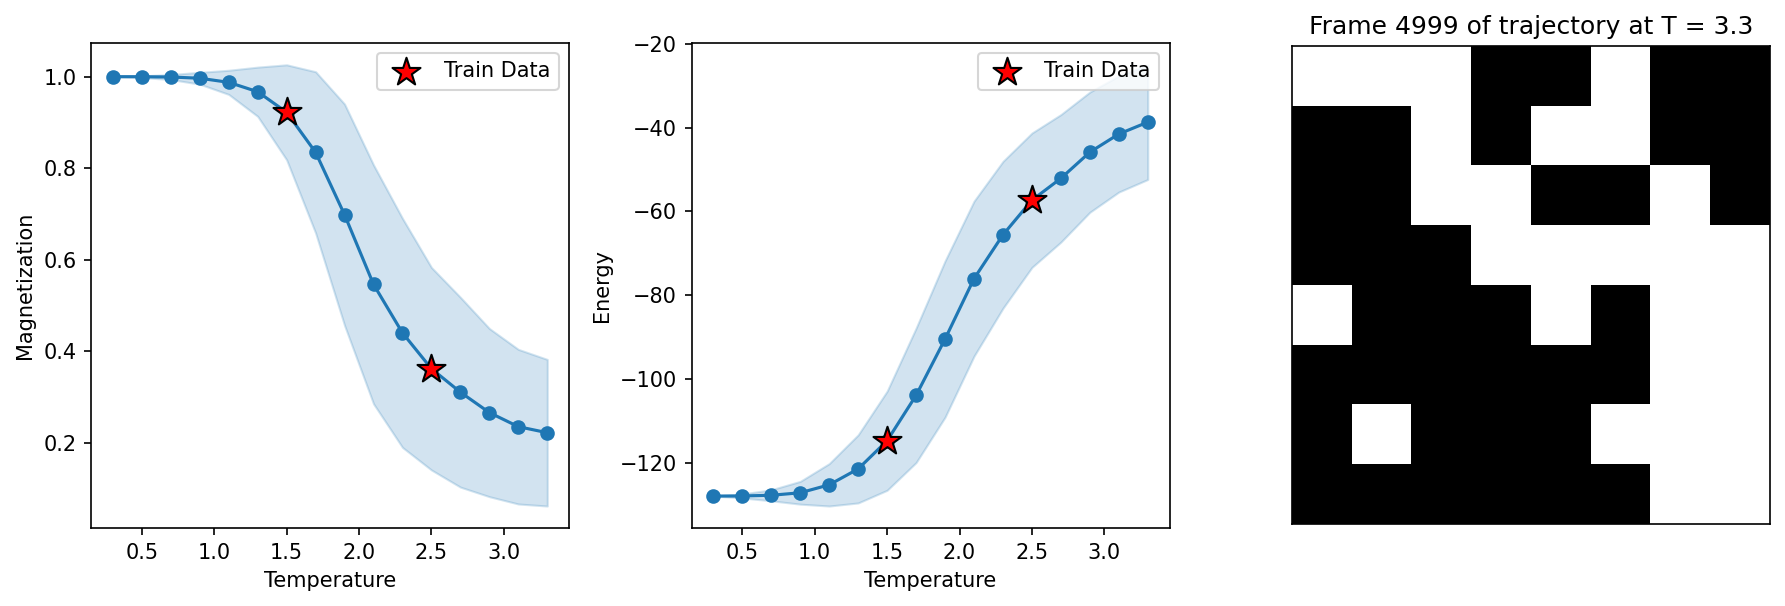

In [132]:
# Vary these to view different trajectories/configurations
trajectory_idx = -1
frame = -1

default_blue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
ax1.plot(list(simulated_M_v_T_mean.keys()), list(simulated_M_v_T_mean.values()), c=default_blue)
ax1.scatter(list(simulated_M_v_T_mean.keys()), list(simulated_M_v_T_mean.values()), c=default_blue)
ax1.scatter(list(train_M_v_T.keys()), list(train_M_v_T.values()),
            c='r', marker='*', edgecolors='k', s=200, zorder=2, label='Train Data')
ax1.fill_between(list(simulated_M_v_T_mean.keys()),
                 [max(m - s, 0) for m, s in zip(simulated_M_v_T_mean.values(), simulated_M_v_T_std.values())],
                 [min(m + s, 1) for m, s in zip(simulated_M_v_T_mean.values(), simulated_M_v_T_std.values())],
                 alpha=0.2, color=default_blue)
ax1.set_ylabel('Magnetization')
ax1.set_xlabel('Temperature')


ax2.plot(list(simulated_E_v_T_mean.keys()), list(simulated_E_v_T_mean.values()), c=default_blue)
ax2.scatter(list(simulated_E_v_T_mean.keys()), list(simulated_E_v_T_mean.values()), c=default_blue)
ax2.scatter(list(train_E_v_T.keys()), list(train_E_v_T.values()),
            c='r', marker='*', edgecolors='k', s=200, zorder=2, label='Train Data')
ax2.fill_between(list(simulated_E_v_T_mean.keys()),
                 [m - s for m, s in zip(simulated_E_v_T_mean.values(), simulated_E_v_T_std.values())],
                 [m + s for m, s in zip(simulated_E_v_T_mean.values(), simulated_E_v_T_std.values())],
                 alpha=0.2, color=default_blue)
ax2.set_ylabel('Energy')
ax2.set_xlabel('Temperature')

img = ax3.imshow(trajectories[-1].coordinates[-1], aspect='equal', cmap='binary')
ax3.set_title(f'Frame {range(len(trajectories[trajectory_idx].coordinates))[frame]} of sim. traj. at T = {trajectories[trajectory_idx].state_variables["temperature"]}')
ax3.set_xticks([])
ax3.set_yticks([])

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()


In [133]:
train_loader, test_loader = sub_dataset.to_TMLoader(train_size=0.8, test_size=0.2, state_variables=['temperature'])

In [134]:
prior = GlobalEquilibriumHarmonicPrior(shape=train_loader.data.shape, channels_info={"coordinate": [0], "fluctuation": [1]})
model = Unet2D(dim=16, dim_mults=(1, 2, 4), resnet_block_groups=8, channels=2)
backbone = ConvBackbone(model=model, data_shape=train_loader.data_dim, target_shape=8, num_dims=4, lr=1e-3, eval_mode="train")
diffusion = VPDiffusion(num_diffusion_timesteps=100)
trainer = DiffusionTrainer(diffusion, backbone, train_loader, model_dir="/content/models", pred_type="noise", prior=prior, device='cuda:0', test_loader=test_loader)

In [ ]:
trainer.train(20, loss_type="smooth_l1", batch_size=8)

In [176]:
sampler = SteeredDiffusionSampler(diffusion, backbone, train_loader, sample_dir='/content/samples', pred_type='noise', prior=prior)

trajectories = []
for temperature in np.arange(0.3, 3.5, 0.2):
  samples = sampler.sample_loop(num_samples=1000, batch_size=1000, temperature=temperature)
  coords = samples[:,0,:,:].numpy()
  coords[coords > 0] = 1
  coords[coords < 0] = -1
  trajectory = EnsembleTrajectory(summary=Summary(info="Generated trajectory"),
                                  state_variables=Summary(temperature=temperature),
                                  coordinates=coords)

  energy = Energy()
  energy.evaluate(trajectory.coordinates)

  mag = Magnetization()
  mag.evaluate(trajectory.coordinates)

  trajectory.add_observable(energy)
  trajectory.add_observable(mag)
  trajectories.append(trajectory)

In [177]:
generated_M_v_T_mean = {t.state_variables['temperature']: t.observables['magnetization'].quantity.mean() for t in trajectories}
generated_E_v_T_mean = {t.state_variables['temperature']: t.observables['energy'].quantity.mean() for t in trajectories}
generated_M_v_T_std = {t.state_variables['temperature']: t.observables['magnetization'].quantity.std() for t in trajectories}
generated_E_v_T_std = {t.state_variables['temperature']: t.observables['energy'].quantity.std() for t in trajectories}

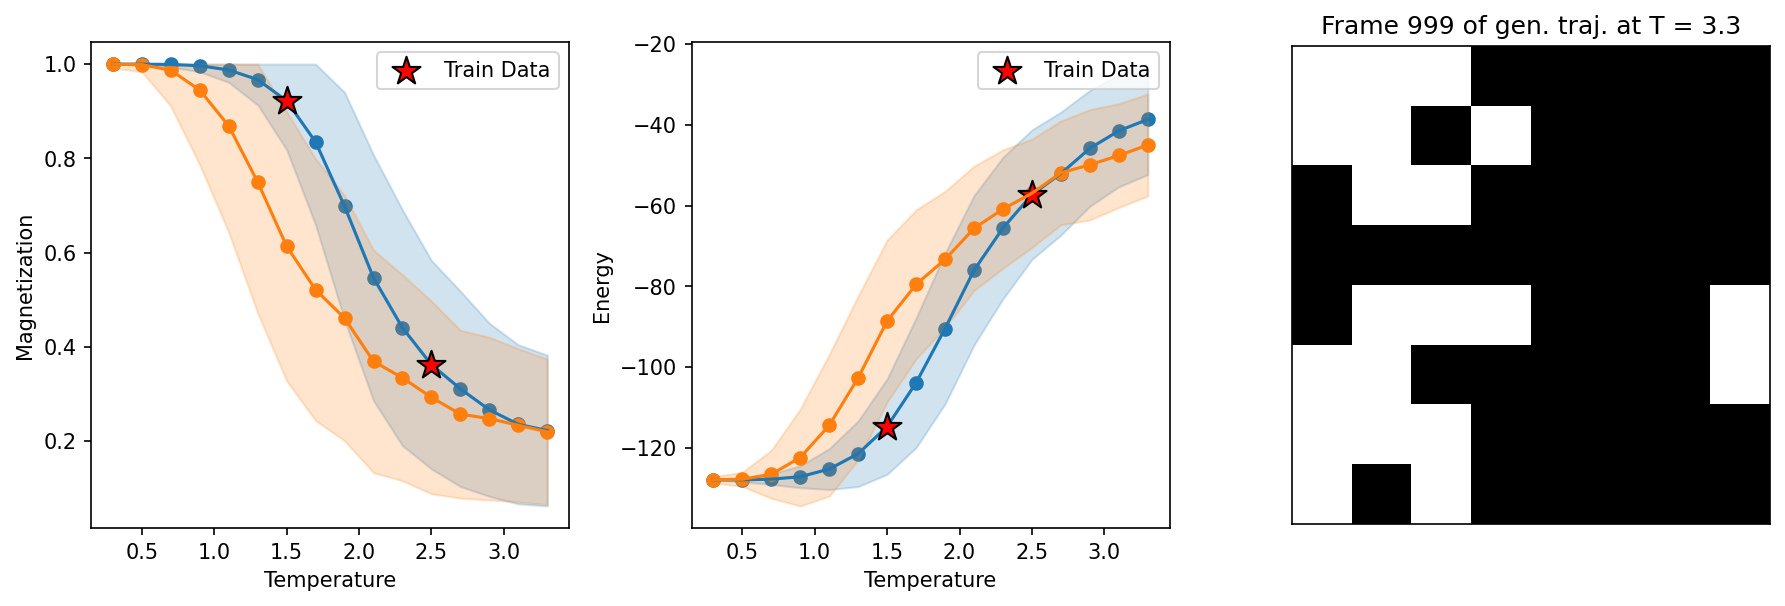

In [198]:
# Vary these to view different trajectories/configurations
trajectory_idx = -1
frame = -1

default_blue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
default_orange = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)

# Plot the simulated ising data
ax1.plot(list(simulated_M_v_T_mean.keys()), list(simulated_M_v_T_mean.values()), c=default_blue)
ax1.scatter(list(simulated_M_v_T_mean.keys()), list(simulated_M_v_T_mean.values()), c=default_blue)
ax1.scatter(list(train_M_v_T.keys()), list(train_M_v_T.values()),
            c='r', marker='*', edgecolors='k', s=200, zorder=2, label='Train Data')
ax1.fill_between(list(simulated_M_v_T_mean.keys()),
                 [max(m - s, 0) for m, s in zip(simulated_M_v_T_mean.values(), simulated_M_v_T_std.values())],
                 [min(m + s, 1) for m, s in zip(simulated_M_v_T_mean.values(), simulated_M_v_T_std.values())],
                 alpha=0.2, color=default_blue)

# Plot the generated ising data
ax1.plot(list(generated_M_v_T_mean.keys()), list(generated_M_v_T_mean.values()), c=default_orange)
ax1.scatter(list(generated_M_v_T_mean.keys()), list(generated_M_v_T_mean.values()), c=default_orange)
ax1.fill_between(list(simulated_M_v_T_mean.keys()),
                 [max(m - s, 0) for m, s in zip(generated_M_v_T_mean.values(), generated_M_v_T_std.values())],
                 [min(m + s, 1) for m, s in zip(generated_M_v_T_mean.values(), generated_M_v_T_std.values())],
                 alpha=0.2, color=default_orange)
ax1.set_ylabel('Magnetization')
ax1.set_xlabel('Temperature')

# Plot the simulated ising data
ax2.plot(list(simulated_E_v_T_mean.keys()), list(simulated_E_v_T_mean.values()), c=default_blue)
ax2.scatter(list(simulated_E_v_T_mean.keys()), list(simulated_E_v_T_mean.values()), c=default_blue)
ax2.scatter(list(train_E_v_T.keys()), list(train_E_v_T.values()),
            c='r', marker='*', edgecolors='k', s=200, zorder=2, label='Train Data')
ax2.fill_between(list(simulated_E_v_T_mean.keys()),
                 [m - s for m, s in zip(simulated_E_v_T_mean.values(), simulated_E_v_T_std.values())],
                 [m + s for m, s in zip(simulated_E_v_T_mean.values(), simulated_E_v_T_std.values())],
                 alpha=0.2, color=default_blue)

# Plot the generated ising data
ax2.plot(list(generated_E_v_T_mean.keys()), list(generated_E_v_T_mean.values()), c=default_orange)
ax2.scatter(list(generated_E_v_T_mean.keys()), list(generated_E_v_T_mean.values()), c=default_orange)
ax2.fill_between(list(simulated_E_v_T_mean.keys()),
                 [m - s for m, s in zip(generated_E_v_T_mean.values(), generated_E_v_T_std.values())],
                 [m + s for m, s in zip(generated_E_v_T_mean.values(), generated_E_v_T_std.values())],
                 alpha=0.2, color=default_orange)
ax2.set_ylabel('Energy')
ax2.set_xlabel('Temperature')

img = ax3.imshow(trajectories[trajectory_idx].coordinates[frame], aspect='equal', cmap='binary')
ax3.set_title(f'Frame {range(len(trajectories[trajectory_idx].coordinates))[frame]} of gen. traj. at T = {trajectories[trajectory_idx].state_variables["temperature"]}')
ax3.set_xticks([])
ax3.set_yticks([])

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()